# Loads the processed h5 file and plots data

In [18]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *
from pedestals import *
from h5_handling import *

In [31]:
# input parameters
run_num = 110

# constants
detector_distance = 0.1249 # m
energy = 9.5 # keV

# hit finders parameters
iq_thr = 0.5 # photon/pix
r_min, r_max = 200,400 # bins

# ice finder parameters
filter_length = 1
ice_thr = 1. # delta photon/pix
q_min, q_max = 1.0,4.5 # A-1

### load and analyse data

In [32]:
# load data
run = discover_run_h5(run_num)[3:-3]
img,Iq,r,nshots,img_hits,thr,nhits,i0,laser_i0,laser_on,event_ID = load_processed_data(run)

# convert q_scale
q = q_scale(r,detector_distance=detector_distance,photon_energy=energy*1000)

# convert intensity to photon/pix
img_hits/=energy
Iq /=energy
i0 /=energy

# normalise to i0
Iq_norm = np.zeros(Iq.shape)
i0_avg = np.average(i0)
norm = i0/i0_avg
for i in range(int(nshots)):
    Iq_norm[i]=Iq[i]/norm[i]

run0110_droplets_10um_28mm: 18000 shots


### find hits, misses and ice

In [33]:
# find hits
metric,hits = find_hits(Iq_norm,threshold=iq_thr,r_min=r_min,r_max=r_max)
hit_rate =len(hits[hits>0])/nshots

# find ice
ice_metric, ice_hits = find_ice(Iq_norm, q, threshold=ice_thr, filter_length=filter_length, q_min=q_min, q_max=q_max)

# exclude ice hits
hits *= np.logical_not(ice_hits)

<IPython.core.display.Javascript object>


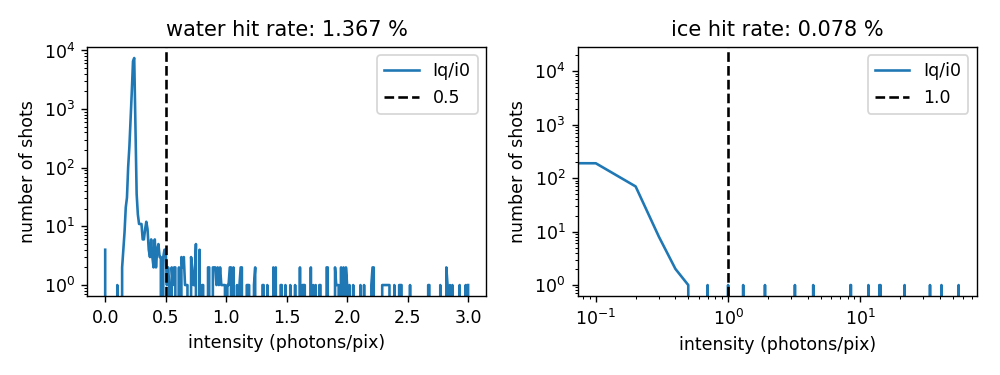

In [34]:
plt.figure(figsize=[8,3])

plt.subplot(1,2,1)
x,y = do_histogram(metric,0,3,.01)
plt.plot(x,y)
plt.axvline(x=iq_thr,c='black',ls='--')
plt.legend(['Iq/i0',iq_thr])
plt.ylabel('number of shots')
plt.yscale('log',nonposy='clip')
#plt.xscale('log',nonposy='clip')
plt.xlabel('intensity (photons/pix)')
plt.title('water hit rate: %.3f %%'%(hit_rate*100))
plt.tight_layout()

plt.subplot(1,2,2)
x,y = do_histogram(ice_metric,0,ice_metric.max(),.1)
plt.plot(x,y)
plt.axvline(x=ice_thr,c='black',ls='--')
plt.legend(['Iq/i0',ice_thr])
plt.ylabel('number of shots')
plt.yscale('log',nonposy='clip')
plt.xlabel('intensity (photons/pix)')
plt.xscale('log',nonposy='clip')
plt.title('ice hit rate: %.3f %%'%(ice_hits.sum()/nshots*100))
plt.tight_layout()

plt.show()

### subtract background

In [35]:
def subtract_background(Iq,hits,i0,nshots):
    '''
    Calculates the average of missed shots and subtracts it as a background
    '''

    # calculate background based on misses
    miss = np.logical_not(hits)

    # calculate background based on normalised misses
    Iq_background = np.average(Iq[miss],axis=0,weights=i0[miss])
    
    # subtract background
    Iq_corr = np.zeros(Iq[hits].shape)
    
    for i in range(np.sum(hits)):
        norm = i0[hits][i]/np.average(i0[hits])
        Iq_corr[i] = Iq[hits][i]/norm - Iq_background/norm
    
    return Iq_corr

In [36]:
Iq_corr = subtract_background(Iq,hits,i0,nshots)

<IPython.core.display.Javascript object>


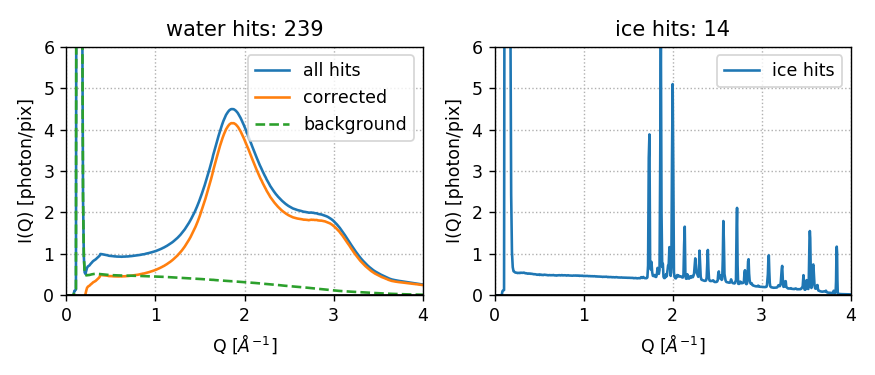

In [37]:
plt.figure(figsize=[7,3])
plt.subplot(1,2,1)
plt.title('water hits: %d'%(hits.sum()))
plt.plot(q, np.average(Iq[hits],axis=0) ,label='all hits')
plt.plot(q, np.average(Iq_corr,axis=0) ,label='corrected')
plt.plot(q, np.average(Iq[hits],axis=0)- np.average(Iq_corr,axis=0) ,'--',label='background')

plt.xlabel('Q [$\AA^{-1}$]')
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right')
plt.axhline(0,c='black',lw=1)
plt.xlim(0,4)
plt.grid(linestyle='dotted')
plt.ylim(0,6)

plt.subplot(1,2,2)
plt.title('ice hits: %d'%(ice_hits.sum()))
plt.plot(q,np.average(Iq[ice_hits],axis=0),label ='ice hits')

plt.xlabel('Q [$\AA^{-1}$]')
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right')
plt.axhline(0,c='black',lw=1)
plt.xlim(0,4)
plt.grid(linestyle='dotted')
plt.ylim(0,6)

plt.tight_layout()
plt.show()

### pump probe signal

In [38]:
def pump_probe_signal_2(Iq,laser_on,r_min=200,r_max=300):
    '''
    calculate the pump probe signal
    '''    
    # important: cast laser_on to boolean (otherwise it messes up the code -ask TJ)
    laser_on = laser_on.astype(bool)
    laser_off = np.logical_not(laser_on)
    
    # laser on and off shots
    Iq_on_avg = np.average(Iq[laser_on],axis=0)
    Iq_off_avg = np.average(Iq[laser_off],axis=0)
    
    # pump-probe
    diff_signal = normalize(Iq_on_avg, r_min, r_max) - normalize(Iq_off_avg, r_min, r_max)
    
    return diff_signal
    

In [39]:
# pump probe (old method)
hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,hits,laser_on,r_min=r_min,r_max=r_max)

# pump probe (new method)
laser_on_hits = laser_on[hits].astype(bool)
diff_signal_2 =  pump_probe_signal_2(Iq_corr,laser_on_hits,r_min,r_max)

### plot

<IPython.core.display.Javascript object>


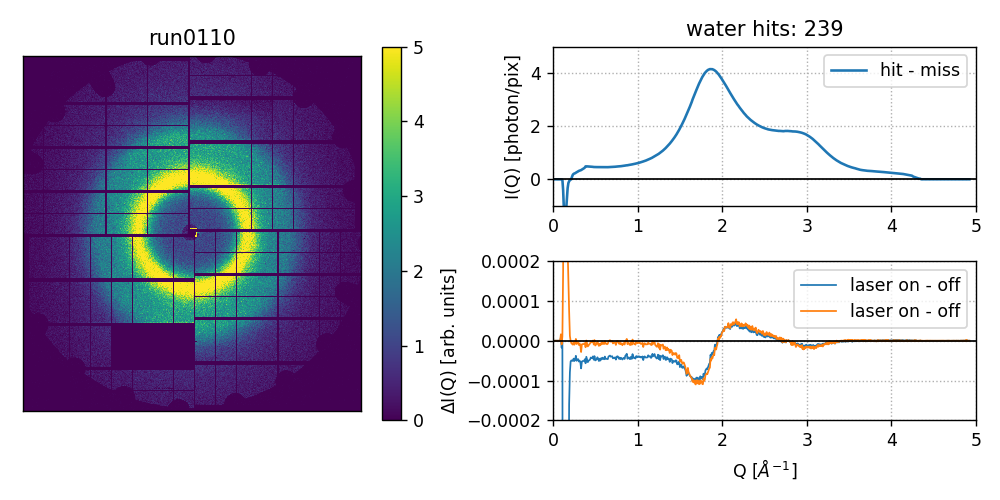

In [42]:
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title('run%s'%run[:4])
plt.imshow(img_hits/nhits,clim=[0,5],origin='lower')
plt.colorbar()
plt.xticks([],'')
plt.yticks([],'')
plt.tight_layout()

plt.subplot(2,2,2)
plt.title('water hits: %d'%(hits.sum()))
plt.plot(q, np.average(Iq_corr,axis=0) , label='hit - miss')
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right')
plt.axhline(0,c='black',lw=1)
plt.xlim(0,5)
plt.grid(linestyle='dotted')
plt.ylim(-1,5)

ax = plt.subplot(2,2,4)
ax.plot(q, diff_signal, label='laser on - off',lw=1)
ax.plot(q, diff_signal_2, label='laser on - off',lw=1)
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.ylim([-2e-4,2e-4])
plt.xlabel('Q [$\AA^{-1}$]')
plt.legend()
plt.xlim(0,5)
plt.grid(linestyle='dotted')
plt.axhline(0,c='black',lw=1)

plt.tight_layout()
plt.show()